In [ ]:
!pip install tensorflow

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import shutil
import os
from sklearn.model_selection import train_test_split

In [24]:
# Parameter
IMG_SIZE = (224, 224)  # Ukuran gambar untuk MobileNetV2
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.001
FINE_TUNE_EPOCHS = 50  # Tambahan epoch untuk fine-tuning
FINE_TUNE_LR = 1e-5    # Learning rate untuk fine-tuning

In [13]:
# Direktori dataset
dataset_dir = "dataset_batik"
train_dir = "train_batik"
test_dir = "test_batik"

# Membuat folder untuk train dan test jika belum ada
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Daftar semua subfolder (kelas)
subfolders = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]

# Membagi data menjadi train dan test
for subfolder in subfolders:
    subfolder_path = os.path.join(dataset_dir, subfolder)
    
    # Membuat folder untuk kelas di dalam folder train dan test
    train_subfolder = os.path.join(train_dir, subfolder)
    test_subfolder = os.path.join(test_dir, subfolder)
    
    os.makedirs(train_subfolder, exist_ok=True)
    os.makedirs(test_subfolder, exist_ok=True)
    
    # Ambil semua gambar di dalam subfolder
    images = [f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]
    
    # Bagi data menggunakan train_test_split
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Pindahkan gambar ke folder train dan test
    for image in train_images:
        old_image_path = os.path.join(subfolder_path, image)
        new_image_path = os.path.join(train_subfolder, image)
        shutil.copy(old_image_path, new_image_path)

    for image in test_images:
        old_image_path = os.path.join(subfolder_path, image)
        new_image_path = os.path.join(test_subfolder, image)
        shutil.copy(old_image_path, new_image_path)

print("Data telah dibagi menjadi folder train dan test.")


Data telah dibagi menjadi folder train dan test.


In [18]:
# Augmentasi Data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Generator Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Informasi jumlah kelas
num_classes = len(train_generator.class_indices)

Found 2718 images belonging to 19 classes.
Found 682 images belonging to 19 classes.


In [19]:
# Verifikasi jumlah gambar di train dan test
for subfolder in os.listdir(train_dir):
    subfolder_path = os.path.join(train_dir, subfolder)
    if os.path.isdir(subfolder_path):
        images = os.listdir(subfolder_path)
        print(f"Train class '{subfolder}' has {len(images)} images.")

for subfolder in os.listdir(test_dir):
    subfolder_path = os.path.join(test_dir, subfolder)
    if os.path.isdir(subfolder_path):
        images = os.listdir(subfolder_path)
        print(f"Test class '{subfolder}' has {len(images)} images.")


Train class 'batik_betawi' has 160 images.
Train class 'batik_celup' has 168 images.
Train class 'batik_cendrawasih' has 159 images.
Train class 'batik_dayak' has 160 images.
Train class 'batik_geblek_renteng' has 168 images.
Train class 'batik_insang' has 160 images.
Train class 'batik_kawung' has 172 images.
Train class 'batik_lasem' has 168 images.
Train class 'batik_mataketeran' has 32 images.
Train class 'batik_megamendung' has 174 images.
Train class 'batik_pala' has 160 images.
Train class 'batik_parang' has 176 images.
Train class 'batik_pintu_aceh' has 32 images.
Train class 'batik_poleng' has 160 images.
Train class 'batik_pring' has 32 images.
Train class 'batik_sekar' has 165 images.
Train class 'batik_sidoluhur' has 135 images.
Train class 'batik_tambal' has 168 images.
Train class 'batik_truntum' has 169 images.
Test class 'batik_betawi' has 40 images.
Test class 'batik_celup' has 42 images.
Test class 'batik_cendrawasih' has 40 images.
Test class 'batik_dayak' has 40 ima

In [20]:
# Model Transfer Learning
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Bekukan layer pada model dasar untuk transfer learning

# Tambahkan lapisan khusus
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout untuk mencegah overfitting
x = Dense(256, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Buat model
model = Model(inputs=base_model.input, outputs=predictions)

# Kompilasi model untuk transfer learning
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Callback
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)


In [21]:
# Pelatihan awal (transfer learning)
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[reduce_lr]
)

Epoch 1/30


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.2654 - loss: 2.5806 - val_accuracy: 0.6012 - val_loss: 1.3982 - learning_rate: 0.0010
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.5767 - loss: 1.3669 - val_accuracy: 0.6745 - val_loss: 1.1325 - learning_rate: 0.0010
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.6566 - loss: 1.1129 - val_accuracy: 0.6701 - val_loss: 1.0836 - learning_rate: 0.0010
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.6860 - loss: 1.0301 - val_accuracy: 0.7126 - val_loss: 0.9901 - learning_rate: 0.0010
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.6972 - loss: 0.9757 - val_accuracy: 0.7419 - val_loss: 0.9207 - learning_rate: 0.0010
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.7356 - loss: 0.8142 - val_accuracy: 0.7581 - val_loss: 0.8672 - learning_rate: 0.0010
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.7528 - loss: 0.8061 - val_accuracy: 0.76

In [22]:
model.save("model_30_epochs.h5")

In [26]:
# Fine-tuning
# Buka beberapa lapisan terakhir dari base model
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Bekukan semua kecuali 20 lapisan terakhir
    layer.trainable = False

# Kompilasi ulang model dengan learning rate yang lebih kecil
model.compile(optimizer=Adam(learning_rate=FINE_TUNE_LR),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Fine-tuning model
history_fine_tune = model.fit(
    train_generator,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=test_generator
)

# Evaluasi model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.8152 - loss: 0.5741 - val_accuracy: 0.7977 - val_loss: 0.7900
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8336 - loss: 0.5123 - val_accuracy: 0.8035 - val_loss: 0.7830
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.8327 - loss: 0.5222 - val_accuracy: 0.8109 - val_loss: 0.7834
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.8414 - loss: 0.4766 - val_accuracy: 0.8094 - val_loss: 0.7845
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.8516 - loss: 0.4723 - val_accuracy: 0.8123 - val_loss: 0.7780
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.8479 - loss: 0.4649 - val_accuracy: 0.8167 - val_loss: 0.7699
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.8646 - loss: 0.4389 - val_accuracy: 0.8196 - val_loss: 0.7668
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8550 - loss: 0.4194 - val_accuracy: 0.8240 - v

In [27]:
model.save("model_90_acc.h5")  # Menyimpan model ke file my_model.h5

Found 682 images belonging to 19 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


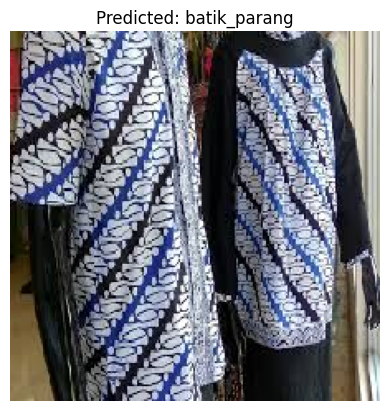

Predicted Label: batik_parang
Prediction Probabilities: [1.07340887e-01 7.01082172e-03 7.30354246e-03 2.83501024e-04
 2.84102163e-03 7.08377920e-04 3.26871028e-04 1.60038460e-03
 2.40758687e-04 2.09987957e-05 3.11711407e-03 5.07412791e-01
 6.21091528e-03 1.29722903e-05 4.95063588e-02 5.36075735e-04
 1.22934386e-01 1.82528600e-01 6.36437544e-05]


In [38]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Fungsi untuk mengklasifikasikan gambar tunggal
def classify_single_image(image_path, model, test_generator, img_size=(224, 224)):
    # Memuat gambar
    img = image.load_img(image_path, target_size=img_size)
    
    # Mengubah gambar menjadi array numpy
    img_array = image.img_to_array(img)
    
    # Normalisasi gambar (menggunakan rescaling seperti di preprocessing data)
    img_array = img_array / 255.0
    
    # Menambahkan dimensi batch (karena model mengharapkan input berupa batch)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Prediksi kelas gambar
    predictions = model.predict(img_array)
    
    # Mendapatkan kelas dengan probabilitas tertinggi
    predicted_class = np.argmax(predictions, axis=1)
    
    # Mengambil label kelas dari test_generator
    class_labels = list(test_generator.class_indices.keys())
    predicted_label = class_labels[predicted_class[0]]
    
    # Menampilkan gambar dan hasil prediksi
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

    return predicted_label, predictions[0]

# Memuat model yang sudah dilatih
model = load_model("model_90_acc.h5")

# Memuat test_generator yang digunakan saat pelatihan
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    "test_batik",  # Ganti dengan direktori data uji Anda
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

# Uji dengan gambar tunggal
image_path = "test_batik/5162737.jpeg"  # Ganti dengan path gambar yang ingin Anda klasifikasikan
predicted_label, prediction_probs = classify_single_image(image_path, model, test_generator)

print(f"Predicted Label: {predicted_label}")
print(f"Prediction Probabilities: {prediction_probs}")
